<a href="https://colab.research.google.com/github/denniesbor/Module_3_Twist/blob/development/TwitterData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h2><strong>Dennies Bor</center></h2></strong>
<center><h2><strong>Module 3 Twist</center></h2></strong>
<center><h2><strong>NLP of Twitter Data</center></h2></strong>

The goal of the project is to perform sentiment analysis and topic modelling of the twitter data for the past one week. The extracted topics are matched with themes of the data queried from the GDELT knowledge database.


In [ ]:
!pip install twython

In [ ]:
import datetime
import time
import tweepy
import pandas as pd
import numpy as np
import nltk
import spacy
import re

import matplotlib.pyplot as plt

from wordcloud import WordCloud
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
tokenizer = ToktokTokenizer()
from nltk.corpus import stopwords
nltk.download("stopwords")
nlp = spacy.load('en_core_web_sm')
from collections import Counter
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## **Twitter Authentication**

Using tweepy to access Twitter developer API



In [ ]:
# add twitter credentials
api_key = '' #Api key from twitter developer account
api_secret_key =  ''   #Api secret key from twitter developer account
access_token = ''        #Api access token from twitter developer account
access_token_secret = ''      #Api access token secret from twitter developer account

# Set the access tokens to complete the authentication process
auth = tweepy.OAuthHandler(api_key, api_secret_key)  
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

# get the place id of Kenya
places = api.geo_search(query="KE", granularity="country")
place_id = places[0].id

**Scraping Twitter**

In [ ]:

def tweets_dataframe(api,n):

    '''This function will extract tweets within Kenya for the past one week,
    and returns as a list of Pandas dataframes.
    
    '''
    df_list = []
    while True:
        date_time = datetime.date.today()               #Acquire today's date
        time_delta1 = datetime.timedelta(days=n)
        time_delta2 = datetime.timedelta(days = n-1)


        # loc = "-1.1014894981627406,34.064256362625386,1500km"               #Set the location of the searches and the radius
        search_words = "place:%s" % place_id # Search words
        # Search dates
        date_since = str(date_time-time_delta1)
        date_until = str(date_time-time_delta2)

        # We also want to exclude retweets and replies as this may sway results
        my_search = search_words + " -filter:retweets" + " -filter:replies"  

        # acquire the tweets
        tweets = tweepy.Cursor(api.search,
                               q=my_search,
                               tweet_mode='extended',
                               since=date_since,
                               until=date_until).items(1000)
        #Obtain the tweets information and pass it into a data frame
        tweet_info = [[tweet.id_str,tweet.created_at,tweet.user.location,tweet.full_text] for tweet in tweets]
        df = pd.DataFrame(data=tweet_info, columns=['tweet_id_str','date_time','location','tweet_text'])
        #append the created dataframe into a list
        df_list.append(df)
        time.sleep(30)
        n = n-1
        if n == 0:
          break
    
    return df_list

df_list = tweets_dataframe(api,3)

# concatenate the returned dfs
df = pd.concat(df_list)

# save for future use
df.to_csv('/content/drive/MyDrive/Kianjokoma/mod_3.csv', index=False)

## **Loading the labelled dataset**
The labelled dataset with sentiment scores is used to train the model and calculate the sentiment scores of the scraped tweets. The dataset is obtained from Kaggle.

In [ ]:
# loading tweets and labelled dataframe

df = pd.read_csv('/content/drive/MyDrive/Kianjokoma/mod3.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Kianjokoma/labelled_data_cleaned.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tweet_id_str  7000 non-null   int64 
 1   date_time     7000 non-null   object
 2   location      6164 non-null   object
 3   tweet_text    7000 non-null   object
dtypes: int64(1), object(3)
memory usage: 218.9+ KB


## **Text Cleaning**
Text cleaning involve dropping duplicates, remove spammed tweets with adverts, swahili, and english stopwords

In [ ]:
# Define our own list of stopwords

my_stopwords = ['...','na','yeah','no','ya','kwa','niggah','nigga',\
                'hapa','ni','Kenya','Kenyans','wa','fuck',
                'know', 'come', 'go', 'well', 'see', 'make', 'take', 'much', 'need', 'gt', 'hii', 'tu', 'nairobi', 'kama', 'sasa', 'and', 'must']
stopwrds = stopwords.words('english')

# Extend the nltk stopwords list
stopwrds.extend(my_stopwords)

# Text cleaning
def clean_text(text):
    
    """
    A function to clean the tweet text
    """
    #Remove hyper links
    text = re.sub(r'&amp;','&',text)
    text = re.sub(r'https?:\/\/\S+', ' ', text)
    
    #Remove @mentions
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text)
    text = re.sub(r'# justiceforkianjokomabrother| # justiceforemmanuelandbenson', ' ',text)
    
    #Remove anything that isn't a letter, number, or one of the punctuation marks listed
    text = re.sub(r"[^A-Za-z0-9]+", ' ', text)
    
    #Create NLP Document
    doc = nlp(text)
    
    # Tokenize the text and remove stopwords
    tokens = [word for word in [str(token.lemma_).strip() for token in doc] 
              if word != '-PRON-' and word not in stopwrds]
    
    filtered_text = ' '.join(tokens)  
    
    return filtered_text.lower()

In [ ]:
df['location'].value_counts()

Nairobi, Kenya               1696
Kenya                         475
Nairobi                       346
Mombasa, Kenya                162
Eldoret, Kenya                127
                             ... 
NAIROBI. kenya                  1
Watamu Coast Kenya              1
Nairobi -Kenya                  1
kitengela- Kajiado, Kenya       1
NAIROBI.KENYA                   1
Name: location, Length: 647, dtype: int64

In [ ]:
# filter tweets which are ads
Adverts = df[df['tweet_text'].str.contains(r'contact \d*|free airtime|advert|available for |@ only kes|Contact 07\d+',re.I,regex=True)]

# extract indices of the ads
ads_indexes= [ad for ad in Adverts.index]

# drop ad tweets
df.drop(index=ads_indexes,inplace =True)

# reset the indices and drop duplicates
df.reset_index(drop=True,inplace=True)
df.drop_duplicates(inplace=True)

# apply the clean text function on the df
df['tweet_text'] = df['tweet_text'].apply(clean_text)

# extract the length of the tweets
df['length_tweet'] = df['tweet_text'].apply(len)

# strip the whitespaces in the texts
df['tweet_text'].str.strip()


In [ ]:
df.head()

,tweet_id_str,date_time,location,tweet_text,length_tweet
0,1512942459566833669,2022-04-09 23:56:06,"Nairobi, Kenya",time ufc help stay australiangp,31
1,1512942434455592962,2022-04-09 23:56:00,nairobi,obligation person year month even 15 minute ag...,66
2,1512941128915599360,2022-04-09 23:50:48,Nairobi-Kenya,tuko area kitengela doubletroubleexperience fu...,90
3,1512941101430288390,2022-04-09 23:50:42,"Nairobi, Kenya",see come one crisis handle well will smith pr ...,103
4,1512940656041381889,2022-04-09 23:48:56,Kenya,close,5


In [ ]:
# check the longest tweet
df[df['length_tweet'] == df['length_tweet'].max()]

,tweet_id_str,date_time,location,tweet_text,length_tweet
3077,1514002381654179851,2022-04-12 22:07:51,"Nyeri, Kenya",mainaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...,275


## **Remove blank tweets**
Some of the tweets in the dataframe are blank, which are removed before topic modelling and sentiment analysis

In [ ]:
# acquire the indices of the blanks
blanks = []
for i,text in enumerate(df['tweet_text']):
  if text == '':
    blanks.append(i)

blank_df = df.iloc[blanks]
df.drop(index=blanks,axis=0,inplace=True)

In [ ]:
blank_df.head(20)

,tweet_id_str,date_time,location,tweet_text,length_tweet
11,1512937144041590796,2022-04-09 23:34:58,Them/They/He/Him🇰🇪🇿🇦,,0
69,1512919601746743309,2022-04-09 22:25:16,"Nairobi, Kenya",,0
84,1512918155613642753,2022-04-09 22:19:31,Nairobi,,0
95,1512915309660880905,2022-04-09 22:08:13,"Nairobi,Kenya",,0
98,1512914844793589763,2022-04-09 22:06:22,Kenya,,0
99,1512914660718174221,2022-04-09 22:05:38,Kenya,,0
101,1512913807508713479,2022-04-09 22:02:14,Kenya,,0
107,1512913284999090185,2022-04-09 22:00:10,NaN,,0
110,1512911975222759434,2022-04-09 21:54:58,Kenya,,0
122,1512910643896201220,2022-04-09 21:49:40,Kenya,,0


**Visualize bold text the most common phrases in wordcloud**

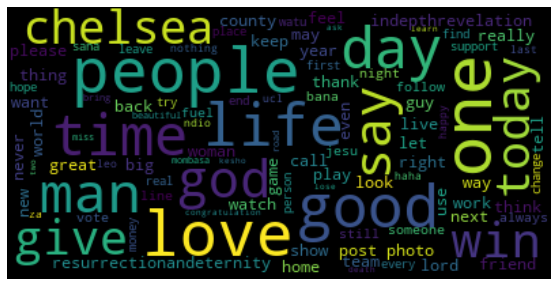

In [ ]:
tweets_ = ' '.join([text for text in df['tweet_text']])
clean_words = []
for word in tweets_.split():
    if word not in stopwrds:
        clean_words.append(word)
word_cloud = WordCloud(max_font_size = 50,background_color='black',max_words=100).generate(' '.join(clean_words))

plt.figure(figsize = (10,5))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## **Google BERT**
Bidirectional Encoder Representation for Transformer (BERT) is an NLP model developed by Google Research in 2018, after its inception it has achieved state-of-the-art accuracy on several NLP tasks.

Transformer architecture has encoder and decoder stack, hence called encoder-decoder architecture whereas BERT is just an encoder stack of transformer architecture. There are two variants, BERT-base and BERT-large, which differ in architecture complexity. The base model has 12 layers in the encoder whereas the Large has 24 layers.

In [ ]:
# extract the tweets for sentiment analysis
tweets = df['tweet_text']

In [ ]:
! git clone https://github.com/google-research/bert.git

Cloning into 'bert'...
remote: Enumerating objects: 340, done.
remote: Total 340 (delta 0), reused 0 (delta 0), pack-reused 340
Receiving objects: 100% (340/340), 328.28 KiB | 19.31 MiB/s, done.
Resolving deltas: 100% (182/182), done.


In [ ]:
!pip install simpletransformers

In [ ]:
from simpletransformers.classification import ClassificationModel

import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import random
import numpy as np
import torch
from sklearn.model_selection import KFold

import logging
from pathlib import Path

In [ ]:
# save the clean dataframe
df.to_csv('/content/drive/MyDrive/Kianjokoma/twitter.csv', index=False)

df = pd.read_csv("/content/drive/MyDrive/Kianjokoma/twitter.csv")

#### **Splitting the labelled dataset for model training. The positive and negative texts are balanced as well.**

In [ ]:
bi_df = df2[(df2.label==0) | (df2.label==2) ] # make it binary classification
bi_df.label.replace(2,1, inplace=True) # make it binary classification

pos_samples = bi_df[bi_df['label']==1]
neg_samples = bi_df[bi_df['label']==0].sample(len(pos_samples), random_state=42)

bal_bi_df = pd.concat([pos_samples, neg_samples])

bi_df['label'].value_counts()
bal_bi_df['label'].value_counts()


train_df, val_df = train_test_split(bi_df, test_size=0.2,  random_state=42)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


1    747
0    747
Name: label, dtype: int64

In [ ]:
# Build the fine tuned Bert model
ct_model = ClassificationModel('bert',
                            'digitalepidemiologylab/covid-twitter-bert',
                            num_labels=2,
                            use_cuda=True,
                            args={'overwrite_output_dir': True})# model param hypertuning

                            
ct_model.args.eval_batch_size = 32
ct_model.args.learning_rate = 2e-05
ct_model.args.num_train_epochs = 2
ct_model.args.evaluate_during_training_verbose = True
ct_model.args.evaluate_during_training = True
# ct_model.args.evaluate_during_training_steps = 100
# ct_model.args.use_cached_eval_features = True
ct_model.args.use_early_stopping = True
ct_model.args.early_stopping_delta = 0
ct_model.args.early_stopping_metric = 'eval_loss'
ct_model.args.early_stopping_metric_minimize = True
ct_model.args.early_stopping_patience = 2

Downloading:   0%|          | 0.00/421 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at digitalepidemiologylab/covid-twitter-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassifi

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

## **wrapper functions**

In [ ]:
%%time

# wrapper functions

def multi_F1(y_true, y_pred, average='macro'):
    return sklearn.metrics.f1_score(y_true=y_true, y_pred=y_pred, average=average)

def multi_classification_report(y_true, y_pred):
    return sklearn.metrics.classification_report(y_true=y_true, y_pred=y_pred)
    
# Train the model 
ct_model.train_model(train_df=train_df, eval_df=val_df)


/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/1819 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/228 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/455 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/228 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/455 [00:00<?, ?it/s]

CPU times: user 2min 28s, sys: 40.6 s, total: 3min 9s
Wall time: 3min 43s


In [ ]:
# save and load the trained model
torch.save(ct_model,'/content/drive/MyDrive/Kianjokoma/model.pth')

ct_model = torch.load('/content/drive/MyDrive/Kianjokoma/model.pth')

In [ ]:
# Calculated and print out the results in the classification report and F1 score

result, model_outputs, wrong_predictions = ct_model.eval_model(val_df, f1=multi_F1);
print('f1 score = ',result['f1'])

result, model_outputs, wrong_predictions = ct_model.eval_model(val_df, report=multi_classification_report);
print('Classification Report: ', result['report'])

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/455 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

f1 score =  0.8699881131989211


/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/455 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

Classification Report:                precision    recall  f1-score   support

         0.0       0.91      0.93      0.92       314
         1.0       0.84      0.80      0.82       141

    accuracy                           0.89       455
   macro avg       0.87      0.87      0.87       455
weighted avg       0.89      0.89      0.89       455



## **Compute the sentiments of each tweet using the pretrained models**

In [ ]:
# returns the sentiment of each tweet
def sentiment_analyser(text):
    result = ct_model.predict([text])
    return result[0][0]

df['sentiment'] = df['tweet_text'].apply(sentiment_analyser)

In [ ]:
# save the dataframe with computed sentiments

df.to_csv('/content/drive/MyDrive/Kianjokoma/sentiment.csv', index=False)

df = pd.read_csv('/content/drive/MyDrive/Kianjokoma/sentiment.csv')

In [ ]:
df.head(5)

,tweet_id_str,date_time,location,tweet_text,length_tweet,sentiment
0,1512942459566833669,2022-04-09 23:56:06,"Nairobi, Kenya",time ufc help stay australiangp,31,1
1,1512942434455592962,2022-04-09 23:56:00,nairobi,obligation person year month even 15 minute ag...,66,0
2,1512941128915599360,2022-04-09 23:50:48,Nairobi-Kenya,tuko area kitengela doubletroubleexperience fu...,90,1
3,1512941101430288390,2022-04-09 23:50:42,"Nairobi, Kenya",see come one crisis handle well will smith pr ...,103,0
4,1512940656041381889,2022-04-09 23:48:56,Kenya,close,5,0


In [ ]:
positive = df[df['sentiment'] == 1]
negative = df[df['sentiment']==0]

**Visualization of sentiments in a pie chart**

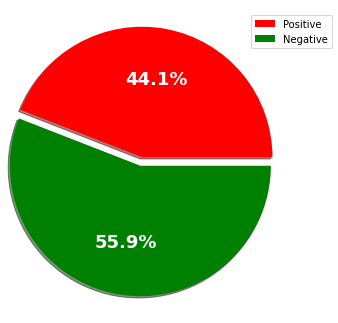

In [ ]:
# visualize sentiment distribution in pie plot

colors = ['red','green']
sizes = [positive.shape[0]/df.shape[0],negative.shape[0]/df.shape[0]]
explode = [0,0.1]
labels = ['Positive','Negative']
plt.pie(x=sizes,labels=labels,explode=explode,colors=colors,shadow=True,radius=1.5,\
        center=(-0.5,1),autopct='%1.1f%%',textprops={'fontsize': 18,'color':'white','weight':'bold'})
plt.legend(loc=(1,1))
plt.show()

From the pie chart, there are more negative to positive sentiments

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


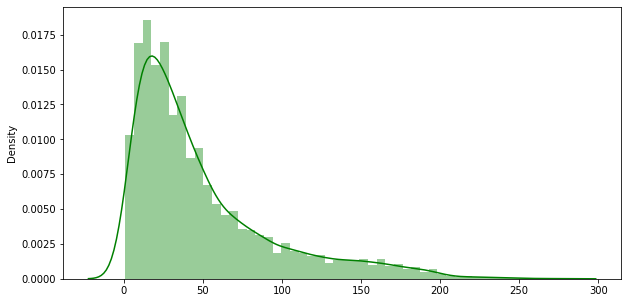

In [ ]:
# visualize distribution of the length of tweets

import seaborn as sns
plt.figure(figsize=(10,5))
sns.distplot(x=df['length_tweet'],color='green')
plt.show()

Majority of the tweets have less than fifty characters

## **Topic Modelling of the Texts - BERTtopic**

BERTopic is a topic modeling technique that leverages hugs transformers and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions.

BERTopic supports guided, (semi-) supervised, and dynamic topic modeling. It even supports visualizations similar to LDAvis!

In [ ]:
!pip install bertopic[gensim] bertopic[spacy]

In [ ]:
from bertopic import BERTopic

# prepare the tweets for topic modelling
timestamps = df.date_time.to_list()
tweets = df.tweet_text.to_list()

topic_model = BERTopic(verbose=True)
topics, probs = topic_model.fit_transform(tweets)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Batches:   0%|          | 0/202 [00:00<?, ?it/s]

2022-04-19 19:33:09,459 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2022-04-19 19:33:48,446 - BERTopic - Reduced dimensionality with UMAP
2022-04-19 19:33:48,769 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_barchart()

In [ ]:
topics_over_time = topic_model.topics_over_time(tweets, topics, timestamps, nr_bins=20)
topic_model.visualize_topics_over_time(topics_over_time)

11it [00:01,  8.77it/s]


In [ ]:
topic_model